#### Code reference : https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
* This Code is not entirely same , there are few changes .

In [1]:
#importing the required libraries
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input 
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add,concatenate
from keras.models import Model

from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


* This function is used to #######documentation uper uper se from mastery

In [15]:
#This function is used to create blocks convolution layers one after other from the list of convolution layer's parameters 
def _conv_block(inp,convs,skip=True):
    x= inp
    count= 0
    for conv in convs:
        if count == (len(convs)-2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: 
            x=ZeroPadding2D(((1,0),(1,0)))(x) #padding as darknet prefer left and top
            
        x = Conv2D(conv['filter'],conv['kernel'],strides=conv['stride'],
                   padding='valid' if conv['stride'] >1 else 'same',#padding as darknet prefer left and top
                  name='conv_' + str(conv['layer_idx']),
                  use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: 
            x =BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']:
            x =LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection,x]) if skip else x

##### ZeroPadding2D : keras.layers.ZeroPadding2D(padding=(1, 1), data_format=None)

* Zero-padding layer for 2D input (e.g. picture).
* This layer can add rows and columns of zeros at the top, bottom, left and right side of an image tensor.  
* **Arguments :-**
padding: If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))

In [22]:
#This function create the model  
def make_yolov3_model():
    input_image = Input(shape=(None,None,3))
    #layer 0 to 4
    x = _conv_block(input_image,[{'filter': 32,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 0},
                                {'filter': 64,'kernel': 3,'stride': 2, 'bnorm': True,'leaky': True ,'layer_idx': 1},
                                {'filter': 32,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 2},
                                {'filter': 64,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 3}])
    
    #layer 5 to 8
    x = _conv_block(x,[{'filter': 128,'kernel': 3,'stride': 2, 'bnorm': True,'leaky': True ,'layer_idx': 5},
                       {'filter': 64,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 6},
                       {'filter': 128,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 7}])
    
    #layer 9 to 11
    x = _conv_block(x,[{'filter': 64,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 9},
                       {'filter': 128,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 10}])
    
    #layer 12 to 15
    x = _conv_block(x,[{'filter': 256,'kernel': 3,'stride': 2, 'bnorm': True,'leaky': True ,'layer_idx': 12},
                       {'filter': 128,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 13},
                       {'filter': 256,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 14}])
    
    #layer 16 to 36
    for i in range(7):
        x = _conv_block(x,[{'filter': 128,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 16+i*3},
                           {'filter': 256,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 17+i*3}])
    
    skip_36=x
    #layer 37 to 40
    x = _conv_block(x,[{'filter': 512,'kernel': 3,'stride': 2, 'bnorm': True,'leaky': True ,'layer_idx': 37},
                       {'filter': 256,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 38},
                       {'filter': 512,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 39}])
    
    #layer 41 to 61
    for i in range(7):
        x = _conv_block(x,[{'filter': 256,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 41+i*3},
                           {'filter': 512,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 42+i*3}])
    
    skip_61=x
    #layer 62 to 65
    x = _conv_block(x,[{'filter': 1024,'kernel': 3,'stride': 2, 'bnorm': True,'leaky': True ,'layer_idx': 62},
                       {'filter': 512,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 63},
                       {'filter': 1024,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 64}])
    
    #layer 66 to 74
    for i in range(3):
        x = _conv_block(x,[{'filter': 512,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 66+i*3},
                           {'filter': 1024,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 67+i*3}])
    
    #layer 75 to 79
    x = _conv_block(x,[{'filter': 512,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 75},
                       {'filter': 1024,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 76},
                       {'filter': 512,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 77},
                       {'filter': 1024,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 78},
                       {'filter': 512,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 79}],skip=False)
    
    #layer 80 to 82
    yolo_82 = _conv_block(x,[{'filter': 1024,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 80},
                           {'filter': 255,'kernel': 1,'stride': 1, 'bnorm': False,'leaky': False ,'layer_idx': 81}],skip=False)
    
    #layer 83 to 86
    x = _conv_block(x,[{'filter': 256,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 84}],skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    
    #layer 87 to 91
    x = _conv_block(x,[{'filter': 256,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 87},
                       {'filter': 512,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 88},
                       {'filter': 256,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 89},
                       {'filter': 512,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 90},
                       {'filter': 256,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 91}],skip=False)
    
    #layer 92 to 94
    yolo_94 = _conv_block(x,[{'filter': 512,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 92},
                           {'filter': 255,'kernel': 1,'stride': 1, 'bnorm': False,'leaky': False ,'layer_idx': 93}],skip=False)
    
    #layer 95 to 98
    x = _conv_block(x,[{'filter': 128,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 96}],skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    
    #layer 99 to 106
    yolo_106 = _conv_block(x,[{'filter': 128,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 99},
                       {'filter': 256,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 100},
                       {'filter': 128,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 101},
                       {'filter': 256,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 102},
                       {'filter': 128,'kernel': 1,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 103},
                       {'filter': 256,'kernel': 3,'stride': 1, 'bnorm': True,'leaky': True ,'layer_idx': 104},
                       {'filter': 255,'kernel': 1,'stride': 1, 'bnorm': False,'leaky': False ,'layer_idx': 105}],skip=False)
    model = Model(input_image,[yolo_82,yolo_94,yolo_106])
    return model

In [21]:
# This function read the weights file that we have downloaded and load it into the memory on the model that we have designed 
# in a particular format. 
# Download the weights file from this link : https://pjreddie.com/media/files/yolov3.weights
class weightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, =struct.unpack('i',w_f.read(4))
            minor, =struct.unpack('i',w_f.read(4))
            revision =struct.unpack('i',w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self,size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #"+str(i))
                if i not in [81,93,105]:
                    norm_layer= model.get_layer("bnorm_"+str(i))
                    size= np.prod(norm_layer.get_weights()[0].shape)
                    beta = self.read_bytes(size) #bias
                    gamma = self.read_bytes(size) #scale
                    mean = self.read_bytes(size) #mean
                    var = self.read_bytes(size) #variance
                    weights = norm_layer.set_weights([gamma,beta,mean,var])
                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else :
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("No Convolution #" + str(i))
                
    def reset(self):
        self.offset = 0

In [23]:
#define the model 
model = make_yolov3_model() 

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
__________________________________________________________________________________________________
zero_paddi

In [24]:
#load the model weights
weight_reader = weightReader('yolov3.weights')

In [25]:
#set the modelweights into the model 
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
No Convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
No Convolution #8
loading weights of convolution #9
loading weights of convolution #10
No Convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
No Convolution #15
loading weights of convolution #16
loading weights of convolution #17
No Convolution #18
loading weights of convolution #19
loading weights of convolution #20
No Convolution #21
loading weights of convolution #22
loading weights of convolution #23
No Convolution #24
loading weights of convolution #25
loading weights of convolution #26
No Convolution #27
loading weights of convolution #28
loading weights of convolution #29
No Convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [26]:
#save the model to file
model.save('model.h5')

#### 

In [2]:
#This function is used to define the parameters for the creation of the bounding box around an object 
class BoundBox:
    def __init__(self,xmin,ymin,xmax,ymax,objness=None,classes=None):
        self.xmin= xmin
        self.ymin= ymin
        self.xmax= xmax
        self.ymax= ymax
        self.objness= objness
        self.classes= classes
        self.label= -1
        self.score= -1
        
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score
    

In [3]:
#Sigmoid fucntion
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [4]:
#This function will take each one of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h,grid_w= netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h,grid_w,nb_box,-1))
    nb_class =netout.shape[-1] - 5
    boxes = []
    netout[..., :2]= _sigmoid(netout[..., :2])
    netout[..., 4:]= _sigmoid(netout[..., 4:])
    netout[..., 5:]= netout[..., 4][...,np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
    for i in range(grid_h*grid_w):
        row= i/grid_w
        col= i%grid_w
        for b in range(nb_box):
            #4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): 
                continue
            # first 4 elements are x,y,w,h 
            x,y,w,h= netout[int(row)][int(col)][b][:4]
            x=(col + x)/grid_w #center position , unit: image width
            y=(row + y)/grid_h #center position, unit: image heigth
            w=anchors[2 *b +0]* np.exp(w) / net_w #unit: image width
            h=anchors[2 *b +1]* np.exp(h) / net_h #unit: image height
            #last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box= BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

In [5]:
#function to fine tune the bounding boxes 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w ,net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w- new_w)/2./net_w,float(new_w)/net_w
        y_offset, y_scale = (net_h- new_h)/2./net_h,float(new_h)/net_h
        boxes[i].xmin =int((boxes[i].xmin-x_offset) / x_scale * image_w)
        boxes[i].xmax =int((boxes[i].xmax-x_offset) / x_scale * image_w)
        boxes[i].ymin =int((boxes[i].ymin-y_offset) / x_scale * image_h)
        boxes[i].ymax =int((boxes[i].ymax-y_offset) / x_scale * image_h)

In [6]:
#fucntion to check whether boxes are overlapping or not.
def _interval_overlap(interval_a,interval_b):
    x1,x2=interval_a
    x3,x4=interval_b
    if x3 < x1: 
        if x4 < x1:
            return 0
        else :
            return min(x2,x4) -x1
    else:
        if x2 < x3:
            return 0
        else :
            return min(x2,x4) -x3

In [7]:
#calculating IOU
def bbox_iou(box1,box2):
    intersect_w = _interval_overlap([box1.xmin,box1.xmax],[box2.xmin,box2.xmax])
    intersect_h = _interval_overlap([box1.ymin,box1.ymax],[box2.ymin,box2.ymax])
    intersect= intersect_w * intersect_h
    w1, h1 =box1.xmax -box1.xmin, box1.ymax- box1.ymin
    w2, h2 =box2.xmax -box2.xmin, box2.ymax- box2.ymin
    union = w1*h1 +w2*h2 - intersect
    return float(intersect) / union

In [8]:
#function to perform NMS
def do_nms(boxes,nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] ==0:
                continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >=nms_thresh:
                    boxes[index_j].classes[c] = 0

In [9]:
#load and prepare an image
def load_image_pixels(filename, shape):
    #load the image to gets its shape
    image = load_img(filename)
    width, height = image.size
    #load the image with the required size
    image = load_img(filename,target_size=shape)
    #convert to numpy array
    image = img_to_array(image)
    #scale pixel values to [0,1]
    image = image.astype('float32')
    image /= 255.0
    #add a dimension so that we have one sample
    image =expand_dims(image,0)
    return image, width,height

In [10]:
#get all of the results above a thresold
def get_boxes(boxes,labels,thresh):
    v_boxes, v_labels,v_scores=list(),list(),list()
    #enumerate all boxes
    for box in boxes:
        #enumerate all possible labels
        for i in range(len(labels)):
            #check if the thresold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                #dont break , many labels may trigger for one box
    return v_boxes,v_labels,v_scores

In [11]:
#draw all results(bounding boxes)
def draw_boxes(filename,v_boxes,v_labels,v_scores,colors):
    #load the image
    data = pyplot.imread(filename)
    #plot the image
    pyplot.imshow(data)
    #get the context for drawing boxes
    ax= pyplot.gca()
    #plot each box
    for i in range(len(v_boxes)):
        box=v_boxes[i]
        #get coordinates
        y1,x1,y2,x2=box.ymin, box.xmin, box.ymax, box.xmax
        #calculate width and height of the box
        width , height=x2-x1,y2-y1
        #create the shape
        rect= Rectangle((x1,y1),width,height,fill=False,color=colors.get(v_labels[i]),linewidth=1.3)
        #draw the box
        ax.add_patch(rect)
        #draw text and score in the top left corner
        label = '%s(%.3f)' %(v_labels[i],v_scores[i])
        pyplot.text(x1,y1,label,color=colors.get(v_labels[i]))
    #show the plot
    pyplot.show()

In [12]:
#colouring different bbox with different colour
def generate_colors(v_labels):
    dictcol=dict()
    colorlist =['blue','red','green','cyan','magenta','yellow','black','white','violet',
               'gold','navy','purple','pink','indigo']
    j=0
    for i in range(len(v_labels)):
        if v_labels[i] not in dictcol.keys() :
            dictcol.update({v_labels[i]:colorlist[j]})
            if(j== len(colorlist)):
                j=0
            else: 
                j += 1
    return dictcol

In [13]:
#load yolov3 model
model= load_model('model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
#define the expected input shape for the model
input_w, input_h = 416,416
#define our new photo
photo_filename='images/zebra.jpg'
#laod and prepare image
image, image_w, image_h= load_image_pixels(photo_filename,(input_w,input_h))

In [15]:
#make prediction
yhat=model.predict(image)
#summarize the shape of the list of arrays
[a.shape for a in yhat]

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]

In [16]:
#define the anchors
anchors = [[116,90,156,198,373,326],[30,61,62,45,59,119],[10,13,16,30,33,23]]
#define the thresold probability for detected objects
class_threshold= 0.6
boxes = list()
for i in range(len(yhat)):
    #decode the output of the network
    boxes += decode_netout(yhat[i][0],anchors[i],class_threshold,input_h,input_w)

In [17]:
#correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes,image_h,image_w,input_h,input_w)
#suppress non-maximal boxes
do_nms(boxes,0.5)

In [18]:
#define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [19]:
#get the details of the detected objects
v_boxes,v_labels,v_scores= get_boxes(boxes,labels,class_threshold)
#summerize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

zebra 94.91057991981506
zebra 99.86329674720764
zebra 96.87087535858154


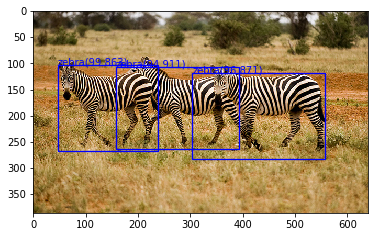

In [20]:
#generate different colors for different classes
colors=generate_colors(v_labels)
#draw what we found
draw_boxes(photo_filename,v_boxes,v_labels,v_scores,colors)

In [21]:
#created a function to just keep everything together
def results(imgtest):
    input_w, input_h = 416,416
    #define our new photo
    photo_filename=imgtest
    image, image_w, image_h= load_image_pixels(photo_filename,(input_w,input_h))
    
    #make prediction
    yhat=model.predict(image)
    print([a.shape for a in yhat])
   
    anchors = [[116,90,156,198,373,326],[30,61,62,45,59,119],[10,13,16,30,33,23]]
    class_threshold= 0.6
    boxes = list()
    for i in range(len(yhat)):
        #decode the output of the network
        boxes += decode_netout(yhat[i][0],anchors[i],class_threshold,input_h,input_w)
    
    correct_yolo_boxes(boxes,image_h,image_w,input_h,input_w)
    do_nms(boxes,0.5)
    v_boxes,v_labels,v_scores= get_boxes(boxes,labels,class_threshold)
    
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
    colors=generate_colors(v_labels)   
    draw_boxes(photo_filename,v_boxes,v_labels,v_scores,colors)

#### Test 2

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.9704897403717
cell phone 96.45482897758484


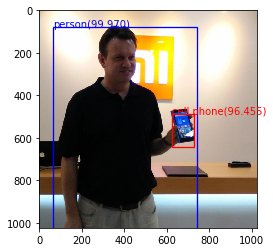

In [22]:
results('images/test1.jpg')

#### Test 3

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 98.60081672668457
car 88.13039064407349
person 94.20852661132812
car 99.55332279205322
car 98.9139974117279
car 68.76899003982544


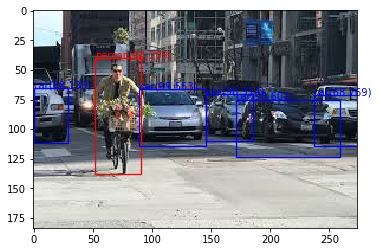

In [23]:
results('images/test2.jpg')

#### Test 4

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
dog 99.86932277679443


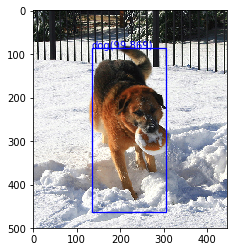

In [24]:
results('images/test3.jpg')

#### Test 5

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
tvmonitor 99.36053156852722
person 99.77546334266663
chair 62.51152753829956
cat 99.45176839828491


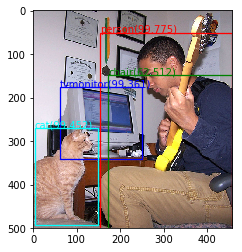

In [25]:
results('images/test4.jpg')